# Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rasterio

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 18.2MB 161kB/s 


## Data loading

In [2]:
%cd '/content/drive/My Drive/sotiris/postgrad/semester2/geo/seira7/repo'
!pwd

/content/drive/My Drive/sotiris/postgrad/semester2/geo/seira7/repo
/content/drive/My Drive/sotiris/postgrad/semester2/geo/seira7/repo


In [5]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt

#normalisation function for each band separately
normalise = lambda x : x / np.max(x)

# Dioni
# read
dioni = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TrainingSet', 'Dioni.tif')).read()
#normalise
dioni = np.array(list(map(normalise, [dioni[i, :, :] for i in range(dioni.shape[0])])))
# view shape
print(dioni.shape)

# Dioni GT
dioni_gt = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TrainingSet', 'Dioni_GT.tif')).read()
print(dioni_gt.shape)

# Loukia
loukia = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TrainingSet', 'Loukia.tif')).read()
loukia = np.array(list(map(normalise, [loukia[i, :, :] for i in range(loukia.shape[0])])))
print(loukia.shape)

# Loukia GT
loukia_gt = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TrainingSet', 'Loukia_GT.tif')).read()
print(loukia_gt.shape)

# Erato
erato = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TestSet', 'Erato.tif')).read()
erato = np.array(list(map(normalise, [erato[i, :, :] for i in range(erato.shape[0])])))
print(erato.shape)

#  Kirki
kirki = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TestSet', 'Kirki.tif')).read()
kirki = np.array(list(map(normalise, [kirki[i, :, :] for i in range(kirki.shape[0])])))
print(kirki.shape)

# Nefeli
nefeli = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TestSet', 'Nefeli.tif')).read()
nefeli = np.array(list(map(normalise, [nefeli[i, :, :] for i in range(nefeli.shape[0])])))
print(nefeli.shape)

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(176, 250, 1376)
(1, 250, 1376)
(176, 249, 945)
(1, 249, 945)
(176, 241, 1632)
(176, 245, 1626)
(176, 249, 772)


# Data preparation for patch based classification

### Batch cropping functions
Combines padding where necessary along with square cropping of variable size around labeled pixels. This process creates a new image training set which provides a patch-based classification method for each labeled pixel. Every patch will be classified according to the label of its central pixel.

In [6]:
def crop_around_pixel(img, y, x, size=5):
    """Crops a hyperspe patch of certain size around a (y, x pixel) """
    startx = x - size//2
    starty = y - size//2
    return img[:, starty:starty+size, startx:startx+size]

def labeled_pixels(gt):
  """Locates labeled pixels in ground truth image"""
  return np.argwhere(gt > 0)[:, [1, 2]]

def pad_image(img, padding):
    """Pads initial large image according to the patch-size selected, so that
    patches do not exceed borders"""
    padded = np.zeros((img.shape[0], img.shape[1] + 2 * padding,
                      img.shape[2] + 2 * padding))
    padded[:, padding:-padding, padding:-padding] = img
    return padded

def patches_supervised(img, gt, size=5):
    """Creates tiles around every labeled pixel of image (supervised approach)
    will be used for supervised training only"""
    padding = size // 2
    img = pad_image(img, padding)
    coords = labeled_pixels(gt)
    patches = [crop_around_pixel(img, yx[0] + padding, yx[1] + padding, size) 
              for yx in coords]
    # supervised approach ignores 0 labels of unclassified pixels so -1
    labels =  np.asarray([gt[:, yx[0], yx[1]] - 1 for yx in coords], dtype="uint8") \
              .flatten()
    return patches, labels


def patches_unsupervised(img, size=15):
  """Creates tiles around every pixel of image (unsupervised approach)
    will be used for inference and unsupervised pretraining"""
    padding = size // 2
    img = pad_image(img, padding)
    coords = np.ndindex(img.shape[1], img.shape[2])
    patches = [crop_around_pixel(img, yx[0] + padding, yx[1] + padding, size) 
              for yx in coords]
    return patches, coords

### Demonstration of batch cropping

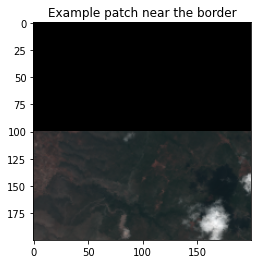

Label of this example patch:  8  =  Dense Sclerophyllous Vegetation
All existing labels:  [ 0  1  2  3  4  6  8  9 10 11 12 13]


In [7]:
patches, labels = patches_supervised(dioni, dioni_gt, size = 200)
patch_composite = patches[0][[23, 11, 7], :, :]
plt.imshow(patch_composite.transpose(1,2,0))
plt.title("Example patch of size 200x200 near the border")
plt.show()
label_names = ["Dense Urban Fabric", "Mineral Extraction Sites", 
               "Non irrigated arable land", "Fruit trees", "Olive Groves", 
               "Broad leaved forest", "Coniferous Forest", "Mixed forest", 
               "Dense Sclerophyllous Vegetation", 
               "Sparse Sclerophyllous Vegetation", "Sparsely Vegetated Areas", 
               "Rocks and Sand", "Water", "Coastal Water"]
print("Label of this example patch: ", labels[0], " = ", label_names[labels[0]])
print("All existing labels: ", np.unique(labels))

### Transformations

In [8]:
import os
import random
from scipy import ndarray
from scipy import ndimage
import skimage as sk
from skimage import util

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-40, 40)
    return ndimage.rotate(input=image_array, angle=random_degree, axes=(1,2),
                          reshape=False)

def random_noise(image_array: ndarray):
    # add a bit of random noise to the image
    return sk.util.random_noise(image_array, mode="gaussian", mean=0, var=0.0001)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, :, ::-1]

def vertical_flip(image_array: ndarray):
    # vertical flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1, :]

# dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip,
    'vertical_flip': vertical_flip,
    'No': lambda x : x
}

### Dataset

In [9]:
from torch.utils.data import Dataset

class HyRank(Dataset):
    def __init__(self, X, y, transform=False, supervision=True):
        self.supervision = supervision
        self.transform = transform
        self.labels = y
        self.patches = X
            
    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        if self.supervision:
            if self.transform:
              key = random.choice(list(self.transform.keys()))
              return {'tensors': self.transform[key](self.patches[idx]).copy(),
                      'labels': self.labels[idx]}
            else:
              return {'tensors': self.patches[idx],
                      'labels': self.labels[idx]}
        else:
            if self.transform:
              key = random.choice(list(self.transform.keys()))
              return {'tensors': self.transform[key](self.patches[idx]).copy(),
                      'labels': self.transform[key](self.patches[idx]).copy()}
            else:
              return {'tensors': self.patches[idx],
                      'labels': self.patches[idx]}


### Train / Test split
In this section, patches of selected dimensions are created and split into train / test / validation sets. Firstly, it is essential to set exclusive subsets of each image to functions as banks of train / test / validation patches so that the respective patches are prevented from overlaps. Overlaps mean cheating that is bad generalisation to the test images. It was considered preferable to split the images horizontally given that such a split retains in the best possible degree the existence of all classes in each set.

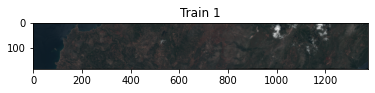

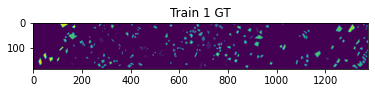

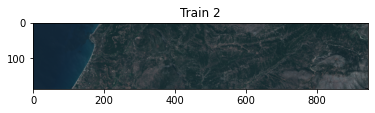

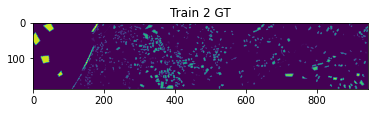

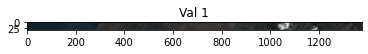

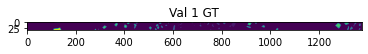

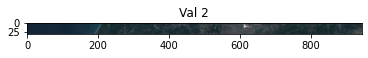

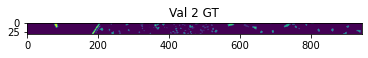

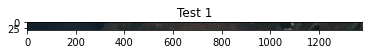

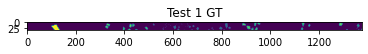

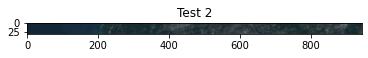

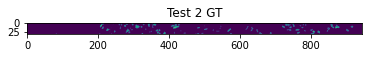

In [11]:
train = [dioni[:, dioni.shape[1]//4:, :], loukia[:, loukia.shape[1]//4:, :]]

val = [dioni[:, dioni.shape[1]//8:dioni.shape[1]//4, :], 
         loukia[:, loukia.shape[1]//8:loukia.shape[1]//4, :]]

test = [dioni[:, :dioni.shape[1]//8, :], 
         loukia[:, :loukia.shape[1]//8, :]]

train_gt = [dioni_gt[:, dioni_gt.shape[1]//4:, :], loukia_gt[:, loukia_gt.shape[1]//4:, :]]

val_gt = [dioni_gt[:, dioni_gt.shape[1]//8:dioni_gt.shape[1]//4, :], 
         loukia_gt[:, loukia_gt.shape[1]//8:loukia_gt.shape[1]//4, :]]

test_gt = [dioni_gt[:, :dioni_gt.shape[1]//8, :], 
         loukia_gt[:, :loukia_gt.shape[1]//8, :]]

dioni_composite = train[0][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Train 1")
plt.show()

dioni_composite = train_gt[0][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Train 1 GT")
plt.show()

dioni_composite = train[1][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Train 2")
plt.show()

dioni_composite = train_gt[1][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Train 2 GT")
plt.show()

dioni_composite = val[0][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Val 1")
plt.show()

dioni_composite = val_gt[0][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Val 1 GT")
plt.show()

dioni_composite = val[1][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Val 2")
plt.show()

dioni_composite = val_gt[1][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Val 2 GT")
plt.show()

dioni_composite = test[0][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Test 1")
plt.show()

dioni_composite = test_gt[0][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Test 1 GT")
plt.show()

dioni_composite = test[1][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Test 2")
plt.show()

dioni_composite = test_gt[1][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Test 2 GT")
plt.show()

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test= []
coords = []

#if supervision:

# patch training set
for (img, gt) in zip(train, train_gt):
    patch, label = patches_supervised(img=img, gt=gt, size=patch_size)
    X_train.extend(patch)
    y_train.extend(label)

  # patch training set
for (img, gt) in zip(val, val_gt):
    patch, label = patches_supervised(img=img, gt=gt, size=patch_size)
    X_val.extend(patch)
    y_val.extend(label)

  # patch training set
for (img, gt) in zip(test, test_gt):
    patch, label = patches_supervised(img=img, gt=gt, size=patch_size)
    X_test.extend(patch)
    y_test.extend(label)
  
# else: # unsupervised = self supervised pretraining
  
# for img in train:
# # I keep the coords so as to know which pixel I infer every time
#   patch, coord_set = patches_unsupervised(img=img, size=patch_size)
#   X_train.extend(patch)
#   coords.extend(coord_set)

### Dataloaders and patch demonstration

torch.Size([128, 176, 15, 15])


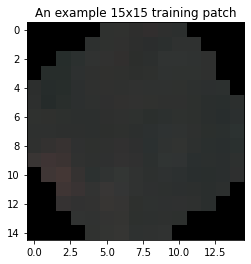

torch.Size([128, 176, 15, 15])


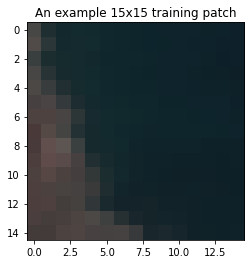

torch.Size([128, 176, 15, 15])


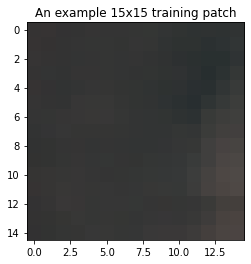

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 176, 15, 15])


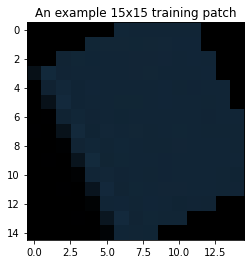

torch.Size([128, 176, 15, 15])


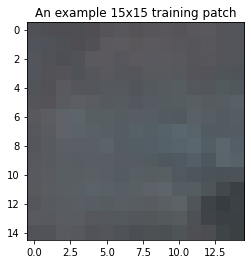

In [12]:
## Dataset
train = HyRank(X=X_train, y=y_train, transform=available_transformations)
val = HyRank(X=X_val, y=y_val, transform=available_transformations)
test = HyRank(X=X_test, y=y_test, transform=available_transformations)
# Dataloaders
from torch.utils.data import DataLoader
trainloader = DataLoader(train, batch_size=batch, num_workers=0, shuffle=True)
valloader = DataLoader(val, batch_size=batch, num_workers=0, shuffle=False)
testloader = DataLoader(test, batch_size=batch, num_workers=0, shuffle=False)

# Demo
i=0
for i, data in enumerate(trainloader):
    i+=1
    print(data["tensors"].shape)
    composite = data["tensors"][-1, [23, 11, 7], :, :].squeeze(0)
    plt.imshow(composite.numpy().transpose(1,2,0))
    plt.title("An example " + str(patch_size) + "x" + str(patch_size) + 
              " training patch")
    plt.show()
    if i==5:
      break